<a href="https://colab.research.google.com/github/ruochee723/SC3000-Balancing-Pole-on-Cart/blob/main/src/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Importing dependencies and define helper functions

In [58]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo

# gymlogger.set_level(40)  # error only
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt

import math
import glob
import io
import base64
import torch

from typing import Tuple

random.seed(42)

## Task 1: Development of an RL agent

In [59]:
env = gym.make("CartPole-v1")

In [60]:
POSITION_RANGE = 4.8
ANGLE_RANGE = 0.418

NUM_BINS = {
    "position": 30,
    "velocity": 30,
    "pole_angle": 30,
    "pole_velocity": 30,
}

In [61]:
def discretize(x: float, min_val: float, max_val: float, num_bins: int) -> int:
    if x > max_val:
        return num_bins - 1
    elif x < min_val:
        return 0
    else:
        return round((x - min_val) / (max_val - min_val) * (num_bins - 1))

In [62]:
from scipy.special import expit as sigmoid
from typing import Dict


def get_num_states():
    num_states = 1
    for num_bins in NUM_BINS.values():
        num_states *= num_bins
    return num_states


NUM_STATES = get_num_states()


class Observation(object):
    def __init__(self, observation):
        if isinstance(observation, tuple):
            observation = observation[0]
        self.observation = observation

    def position(self):
        return self.observation[0]

    def velocity(self):
        return self.observation[1]

    def pole_angle(self):
        return self.observation[2]

    def pole_velocity(self):
        return self.observation[3]

    def get_hashed_state_dict(self) -> Dict[str, int]:
        return {
            "position": discretize(
                self.position(), -POSITION_RANGE, POSITION_RANGE, NUM_BINS["position"]
            ),
            "velocity": discretize(
                sigmoid(self.velocity()),
                -1,
                1,
                NUM_BINS["velocity"],
            ),
            "pole_angle": discretize(
                self.pole_angle(), -ANGLE_RANGE, ANGLE_RANGE, NUM_BINS["pole_angle"]
            ),
            "pole_velocity": discretize(
                sigmoid(self.pole_velocity()),
                -1,
                1,
                NUM_BINS["pole_velocity"],
            ),
        }

    def get_hashed_state(self) -> int:
        hashed_state_tuple = self.get_hashed_state_dict()
        mul = 1
        hashed_state = 0
        for key, val in hashed_state_tuple.items():
            hashed_state += val * mul
            mul *= NUM_BINS[key]
        assert 0 <= hashed_state < NUM_STATES
        return hashed_state
    
    def get_vector(self) -> torch.Tensor:
        return torch.tensor(self.observation, dtype=torch.float32).unsqueeze(0)


def get_hashed_state(observation: np.ndarray) -> int:
    return Observation(observation).get_hashed_state()

### Abstract Class for RL Agent

In [63]:
from abc import ABC, abstractmethod


class Agent(ABC):
    def __init__(self, name: str):
        self.name = name

    @abstractmethod
    def _get_action(self, observation: Observation) -> int:
        raise NotImplementedError

    def get_action(self, observation: np.ndarray) -> int:
        return self._get_action(Observation(observation))

    def __call__(self, observation: np.ndarray) -> int:
        return self.get_action(observation)

### Random Agent

In [97]:
class RandomAgent(Agent):
    def __init__(self):
        super().__init__("RandomAgent")

    def _get_action(self, observation: Observation) -> int:
        return random.randint(0, 1)

### Q Learning Agent

In [65]:
import os
import yaml
from tqdm import trange


class QLearningAgent(Agent):
    def __init__(
        self,
        *,
        state_space_size: int = NUM_STATES,
        action_space_size: int = 2,
        alpha: float = 0.1,
        gamma: float = 0.99,
        epsilon: float = 0.1,
    ):
        super().__init__("QLearningAgent")
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((state_space_size, action_space_size))

    def reset(self):
        self.q_table = np.zeros((self.state_space_size, self.action_space_size))

    def _get_action(self, observation: Observation) -> int:
        return np.argmax(self.q_table[observation.get_hashed_state(), :])

    def train_episode(self, env: gym.Env):
        observation = env.reset()
        state = get_hashed_state(observation)
        done = False
        truncated = False
        sum_reward = 0
        while not done and not truncated and sum_reward < 500:
            if random.random() < self.epsilon:
                action = random.randint(0, 1)
            else:
                action = self.get_action(observation)
            next_observation, reward, done, truncated, info = env.step(action)
            next_state = get_hashed_state(next_observation)
            self.q_table[state, action] += self.alpha * (
                reward
                + self.gamma * np.max(self.q_table[next_state, :])
                - self.q_table[state, action]
            )
            sum_reward += reward
            state = next_state
            observation = next_observation

    def train(self, env: gym.Env = None, *, num_episodes: int = 1000) -> np.ndarray:
        if env is None:
            env = gym.make("CartPole-v1")
        episode_rewards = []
        for episode in trange(
            num_episodes, desc="Training Q-Learning Agent", unit="episode"
        ):
            episode_rewards.append(self.train_episode(env))

    def save(
        self,
        path: str,
        *,
        q_file_name: str = "q_table.npy",
        model_info_name: str = "model_info.yaml",
    ):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        np.save(os.path.join(path, q_file_name), self.q_table)
        with open(os.path.join(path, model_info_name), "w") as f:
            yaml.safe_dump(
                {
                    "state_space_size": self.state_space_size,
                    "action_space_size": self.action_space_size,
                    "alpha": self.alpha,
                    "gamma": self.gamma,
                    "epsilon": self.epsilon,
                },
                f,
            )

    def load(
        self,
        path: str,
        *,
        q_file_name: str = "q_table.npy",
        model_info_name: str = "model_info.yaml",
    ):
        self.q_table = np.load(os.path.join(path, q_file_name))
        with open(os.path.join(path, model_info_name), "r") as f:
            model_info = yaml.safe_load(f)
        self.state_space_size = model_info["state_space_size"]
        self.action_space_size = model_info["action_space_size"]
        self.alpha = model_info["alpha"]
        self.gamma = model_info["gamma"]
        self.epsilon = model_info["epsilon"]

In [113]:
import torch


class QNetwork(torch.nn.Module):
    def __init__(self, state_space_dim: int, action_space_size: int, cuda: bool = True):
        super(QNetwork, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(state_space_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            # torch.nn.Linear(128, 128),
            # torch.nn.ReLU(),
            # torch.nn.Linear(128, 128),
            # torch.nn.ReLU(),
            torch.nn.Linear(128, action_space_size),
        )
        # self.layer1 = torch.nn.Linear(state_space_dim, 128)
        # self.layer2 = torch.nn.Linear(128, 128)
        # self.layer3 = torch.nn.Linear(128, action_space_size)
        # if cuda and torch.cuda.is_available():
        #     self.device = torch.device("cuda")
        # self.loss_fn = torch.nn.MSELoss()
        # self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

    def forward(self, state):
        return self.model(state)
        # x = torch.nn.functional.relu(self.layer1(state))
        # x = torch.nn.functional.relu(self.layer2(x))
        # return self.layer3(x)

import itertools
from collections import deque, namedtuple

Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DeepQLearning(Agent):
    def __init__(
        self,
        state_space_dim,
        action_space_size,
        batch_size = 128,
        gamma=0.99,
        start_epsilon=0.9,
        end_epsilon=0.05,
        epsilon_decay=1000,
        tau=0.005,
        lr=1e-4,
        memory_capacity: int = 10000,
        enable_cuda: bool = True,
    ):
        super().__init__("DeepQLearning")
        self.batch_size = batch_size
        self.gamma = gamma
        self.start_epsilon = start_epsilon
        self.end_epsilon = end_epsilon
        self.epsilon_decay = epsilon_decay
        self.tau = tau
        self.lr = lr
        self.epsilon = start_epsilon
        if enable_cuda:
            self.device = (
                "cuda:0"
                if torch.cuda.is_available()
                else "mps" if torch.backends.mps.is_available() else "cpu"
            )
        else:
            self.device = "cpu"
        gymlogger.info(f"Using {self.device} device")
        self.policy_net = QNetwork(state_space_dim, action_space_size).to(self.device)
        self.target_net = QNetwork(state_space_dim, action_space_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = torch.optim.AdamW(
            self.policy_net.parameters(), lr=self.lr, amsgrad=True
        )
        self.memory = ReplayMemory(memory_capacity)
        
    def get_action_vec(self, observation: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            return self.policy_net(observation).max(1).indices.view(1, 1)
        
    def _get_action(self, observation: Observation) -> int:
        return self.get_action_vec(observation.get_vector().to(self.device)).item()

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        
        transitions = self.memory.sample(self.batch_size)
        
        batch = Transition(*zip(*transitions))
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,batch.next_state)), device=self.device, dtype=torch.bool)

        non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1).values
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute Huber loss
        criterion = torch.nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
    
    def train(self, env: gym.Env, num_episodes: int = 50):
        for i_episode in trange(num_episodes, desc="Training Deep Q-Learning Agent", unit="episode"):
            # Initialize the environment and get its state
            state, info = env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            for t in itertools.count():
                if random.random() < self.epsilon:
                    action = torch.tensor([[env.action_space.sample()]], device=self.device, dtype=torch.long)
                else:
                    action = self.get_action_vec(state)
                observation, reward, terminated, truncated, _ = env.step(action.item())
                reward = torch.tensor([reward], device=self.device)
                done = terminated or truncated

                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0)

                # Store the transition in memory
                self.memory.push(state, action, next_state, reward)

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                self.optimize_model()

                # Soft update of the target network's weights
                # θ′ ← τ θ + (1 −τ )θ′
                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)
                self.target_net.load_state_dict(target_net_state_dict)

                if done:
                    break

For Task 1, we can show the observation and chosen action below:

In [109]:
env.reset()
q_learning_agent = QLearningAgent()
q_learning_agent.train(env)
observation = env.reset()
action = q_learning_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Training Q-Learning Agent:   0%|          | 0/1000 [00:00<?, ?episode/s]

Training Q-Learning Agent: 100%|██████████| 1000/1000 [00:01<00:00, 708.39episode/s]

Observation: (array([-0.01605115,  0.03070746,  0.04593599, -0.03541347], dtype=float32), {})
Chosen action: 1


In [110]:
env.reset()
deep_q_learning_agent = DeepQLearning(state_space_dim=4, action_space_size=2, enable_cuda=False)
deep_q_learning_agent.train(env)
observation = env.reset()
print("Observation:", observation)
action = deep_q_learning_agent(observation)
# print("Observation:", observation)
# print("Chosen action:", action)

Training Deep Q-Learning Agent: 100%|██████████| 50/50 [00:04<00:00, 11.35episode/s]

Observation: (array([-0.04682643,  0.03032948, -0.03790564,  0.03275852], dtype=float32), {})


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

In [69]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor


def play_episode(agent: Agent, env: gym.Env) -> float:
    observation = env.reset()
    done = False
    truncated = False
    reward = 0
    while not done and not truncated and reward < 500:
        action = agent(observation)
        next_observation, r, done, truncated, info = env.step(action)
        reward += r
        observation = next_observation
    reward = min(reward, 500)
    return reward


def play(agent: Agent, num_episodes: int = 1000, num_threads: int = 1):
    all_rewards = []

    progress_bar = tqdm(total=num_episodes, desc="Playing", unit="episode")

    def play_multiple_episodes(episodes: int, rank: int):
        env = gym.make("CartPole-v1")
        rewards = []
        for i in range(episodes):
            progress_bar.update(1)
            rewards.append(play_episode(agent, env))
        return rewards

    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        threads_loads = [num_episodes // num_threads] * num_threads
        threads_loads[-1] += num_episodes % num_threads
        all_rewards = sum(
            executor.map(play_multiple_episodes, threads_loads, range(num_threads)), []
        )

    progress_bar.close()

    return np.array(all_rewards)

In [111]:
env.reset()
deep_q_learning_agent = DeepQLearning(state_space_dim=4, action_space_size=2, enable_cuda=True)
deep_q_learning_agent.train(env, num_episodes=1000)
observation = env.reset()
print("Action:", deep_q_learning_agent(observation))

Training Deep Q-Learning Agent:   0%|          | 0/1000 [00:00<?, ?episode/s]

Training Deep Q-Learning Agent: 100%|██████████| 1000/1000 [02:28<00:00,  6.72episode/s]

Action: 0


Playing: 100%|██████████| 100/100 [00:26<00:00,  3.78episode/s]


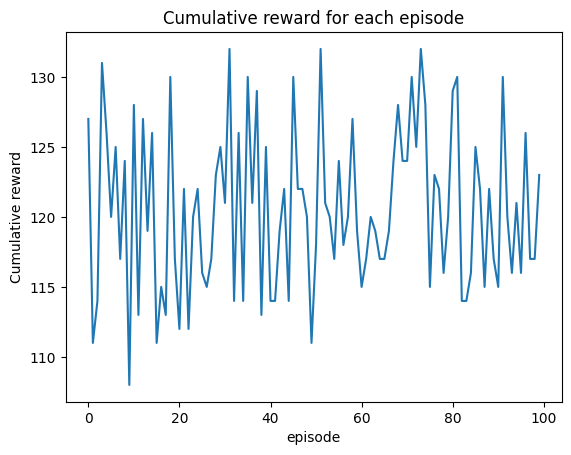

In [112]:
episode_results = play(deep_q_learning_agent, num_episodes=100, num_threads=30)
plt.plot(episode_results)
plt.title("Cumulative reward for each episode")
plt.ylabel("Cumulative reward")
plt.xlabel("episode")
plt.show()

In [70]:
q_learning_agent = QLearningAgent(alpha=0.1, epsilon=0.5, gamma=0.999)
q_learning_agent.train(env, num_episodes=10000)
q_learning_agent.alpha = 0.05
q_learning_agent.epsilon = 0.1
q_learning_agent.train(env, num_episodes=10000)
episode_results = play(q_learning_agent, num_episodes=100, num_threads=30)
plt.plot(episode_results)
plt.title("Cumulative reward for each episode")
plt.ylabel("Cumulative reward")
plt.xlabel("episode")
plt.show()

Training Q-Learning Agent:  38%|███▊      | 3788/10000 [00:09<00:15, 393.41episode/s]


KeyboardInterrupt: 

Print the average reward over the 100 episodes.

In [101]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 135.57
Is my agent good enough? False


## Task 3: Render one episode played by the agent

In [75]:
import os
import imageio
import datetime
from PIL import Image
from IPython.display import Video


def get_video_path(
    agent: Agent, *, video_name: str = "default", video_folder: str = "video"
) -> str:
    os.makedirs(video_folder, exist_ok=True)
    if video_name == "default":
        video_name = f"{agent.name}_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}"
    if not video_name.endswith(".mp4"):
        video_name += ".mp4"
    return os.path.join(video_folder, video_name)


def render(
    agent: Agent,
    video_name: str = "default",
    fps: int = 20,
    width: int = 600,
    height: int = 400,
    video_folder: str = "video",
):
    env = gym.make("CartPole-v1", render_mode="rgb_array")

    frames = []
    observation = env.reset()
    while True:
        frames.append(Image.fromarray(env.render()).resize((width, height)))
        action = agent(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            break

    env.close()

    video_path = get_video_path(agent, video_name=video_name, video_folder=video_folder)
    imageio.mimsave(video_path, frames, fps=fps)

    return Video(video_path)

In [ ]:
render(q_learning_agent)

: 

In [104]:
render(deep_q_learning_agent)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x62d4c40] Warning: data is not aligned! This can lead to a speed loss
